#Drive Mount for Connecting Model with Datasets


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Importing Libraries Required For The Model. 

In [ ]:
import tensorflow as tf 

import os
import datetime

import random
import glob
import shutil

import numpy as np
import itertools

from sklearn.metrics import confusion_matrix

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout, Input, LeakyReLU, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta
from tensorflow.keras.metrics import categorical_crossentropy

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.applications.nasnet import NASNetMobile
# from tensorflow.keras.applications.nasnet import preprocess_input

from tensorflow.keras.applications.densenet import DenseNet121
# from tensorflow.keras.applications.densenet import preprocess_input

from PIL import Image

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#Displaying Dataset

In [ ]:
def show_data(path=None, count=3, title=None):
  
  fig = plt.figure(figsize=(10, 10))
    
  for i in range(count):
  
    file = random.choice(os.listdir(path))
  
    image_path = os.path.join(path, file)
    image = mpimg.imread(image_path)
  
    ax=plt.subplot(3, 3, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
  
    plt.imshow(image)
  
  fig.suptitle(title, fontsize = 30)
  plt.tight_layout()
  fig.subplots_adjust(top=0.93)

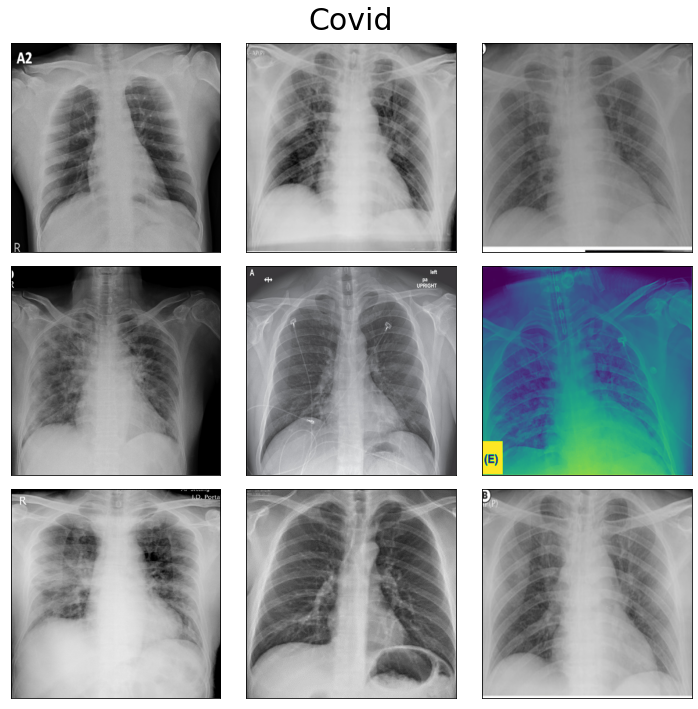

In [ ]:
path = '/content/drive/Shared drives/Higher Studies Paper Prep/Datasets/RadiographyImages/Train/covid'
show_data(path=path, count=9, title='Covid')
plt.savefig('covid.png')

In [ ]:
'''
from google.colab import files
files.download('Combined.jpg')
files.download('COVID.png')
files.download('NORMAL.png')
files.download('PNEUMONIA.png')
'''

"\nfrom google.colab import files\nfiles.download('Combined.jpg')\nfiles.download('COVID.png')\nfiles.download('NORMAL.png')\nfiles.download('PNEUMONIA.png')\n"

# Preparing Images for Data Preprocessing



In [ ]:
def date_time(x):
  if x==1:
    return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())

In [ ]:
train_path = "/content/drive/Shared drives/Higher Studies Paper Prep/Datasets/RadiographyImages/Train"
valid_path = "/content/drive/Shared drives/Higher Studies Paper Prep/Datasets/RadiographyImages/Validation"
test_path = "/content/drive/Shared drives/Higher Studies Paper Prep/Datasets/RadiographyImages/Test"

In [ ]:
def create_data(train_path=None, valid_path=None, batch_size=8, target_size=(200,200), preprocess_input=None, color_model='rgb'):
  
  train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
  valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(directory = train_path,
                                                   target_size = target_size,
                                                   color_mode = 'rgb',
                                                   batch_size = batch_size,
                                                   shuffle = True,
                                                   seed = 42) 
  valid_generator = valid_datagen.flow_from_directory(directory = valid_path,
                                                  target_size = target_size,
                                                  color_mode = 'rgb',
                                                  batch_size = batch_size,
                                                  shuffle = True,
                                                  seed = 42)
  test_generator = test_datagen.flow_from_directory(directory = test_path,
                                                    target_size = target_size,
                                                    batch_size = 5,
                                                    shuffle=False)
    
  STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
  STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

  return train_generator, valid_generator, test_generator, STEP_SIZE_TRAIN, STEP_SIZE_VALID

#HYPERPARAMETERS

In [ ]:
INIT_LR = 3e-4
EPOCHS = 25
BS = 8
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

#PREPROCESSING THE DATA FOR OUR VGG16 MODEL

In [ ]:
preprocess_input = tf.keras.applications.nasnet.preprocess_input
train, valid, test, step_train, step_valid = create_data(train_path=train_path, valid_path=valid_path, target_size=(224,224), preprocess_input=preprocess_input)

Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 188 images belonging to 2 classes.


#ADDING LAYERS ON TOP OF VGG16, TO CUSTOMISE OUR MODEL AND MAKE IT GENERALIZE BETTER ON OUR DATASET

In [ ]:
baseModel = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = LeakyReLU(alpha=0.4)(headModel)
headModel = Dropout(0.6)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

#THE FINAL MODEL ARCHITECTURE

In [ ]:
model = Model(inputs=baseModel.input, outputs=headModel)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

#FREEZING ALL THE LAYERS IN THE BASE MODEL i.e. VGG16

In [ ]:
for layer in baseModel.layers:
  layer.trainable = False

#model.summary()

In [ ]:
# compiling the model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

#TRAINING THE MODEL

In [ ]:
H = model.fit_generator(
		train,
		steps_per_epoch=step_train,
		validation_data=valid,
		validation_steps=step_valid,
		epochs=EPOCHS)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
25/25 [==============================] - 10s 379ms/step - loss: 0.7852 - accuracy: 0.4710 - val_loss: 0.6590 - val_accuracy: 0.7050
Epoch 2/25
25/25 [==============================] - 9s 361ms/step - loss: 0.7218 - accuracy: 0.5685 - val_loss: 0.6026 - val_accuracy: 0.8950
Epoch 3/25
25/25 [==============================] - 9s 363ms/step - loss: 0.5807 - accuracy: 0.7949 - val_loss: 0.5548 - val_accuracy: 0.9700
Epoch 4/25
25/25 [==============================] - 9s 366ms/step - loss: 0.5779 - accuracy: 0.7630 - val_loss: 0.5065 - val_accuracy: 0.9750
Epoch 5/25
25/25 [==============================] - 9s 359ms/step - loss: 0.5139 - accuracy: 0.8307 - val_loss: 0.4639 - val_accuracy: 0.9750
Epoch 6/25
25/25 [==============================] - 9s 362ms/step - loss: 0.5277 - accuracy: 0.8465 - val_loss: 0.4241 - val_accuracy: 0.9750
Epoch 7/25
25/25 [==============================] - 9s 362ms/step - loss: 0.4312 - accuracy: 0.9151 - val_loss: 0.3865 - val_accuracy: 0.9750
Epoch

#Saving the Model

In [ ]:
# saving the model
'''
model.save('C_VGG16_Adam_25')
'''

"\nmodel.save('C_VGG16_Adam_25')\n"

In [ ]:
# saving the saved model from colaboratory on our local machine
'''
from google.colab import files
files.download('C_VGG16_Adam_25/saved_model.pb')
'''

"\nfrom google.colab import files\nfiles.download('C_VGG16_Adam_25/saved_model.pb')\n"

# A function to plot the accuracy and loss of our models with the progression of epochs

In [ ]:


def performance_plot(history = None):
  legends = ['training', 'validation']
  plt.figure(figsize=(20,5))

  y1 = history.history['accuracy']
  y2 = history.history['val_accuracy']
  
  plt.subplot(121)
  plt.plot(y1)
  plt.plot(y2)

  plt.title('Model Accuracy\n'+date_time(1), fontsize=18)
  plt.xlabel('Epochs', fontsize=15)
  plt.ylabel('Accuracy', fontsize=15)
  plt.legend(legends, loc='upper left')
  plt.grid()

  y1 = history.history['loss']
  y2 = history.history['val_loss']

  plt.subplot(122)
  plt.plot(y1)
  plt.plot(y2)

  plt.title('Model Loss\n'+date_time(1), fontsize=18)
  plt.xlabel('Epochs', fontsize=15)
  plt.ylabel('Loss', fontsize=15)
  plt.legend(legends, loc='upper left')
  plt.grid()

  plt.savefig('plot.png')

  plt.show()

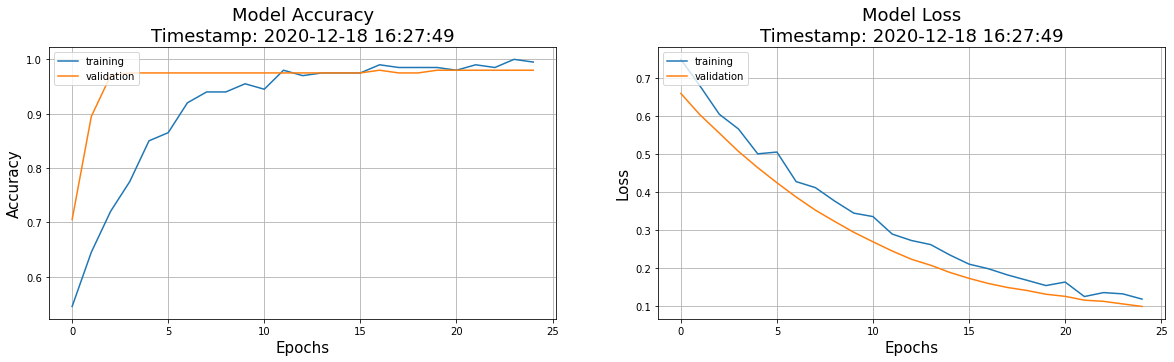

In [ ]:
performance_plot(history=H)

In [ ]:
test_labels = test.classes
print(test_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]


In [ ]:
predictions = model.predict(x=test, steps=len(test), verbose=0)

#Confusion Matrix


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('cm.jpg')


Confusion matrix, without normalization
[[ 73   0]
 [  0 115]]


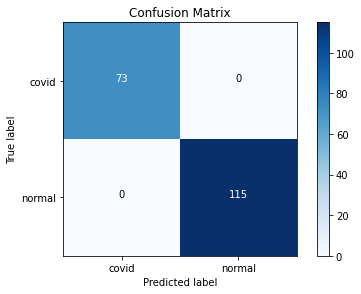

In [ ]:
cm = confusion_matrix(y_true=test.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['covid','normal']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

#Model Accuracy, Sensitivity, and Specificity

In [ ]:
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity

#print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000
